# CNN evaluation function for chess positions from the lichess puzzle database
The dataset that I use is a CSV modified from the original 3.9M record lichess puzzle database. I've run about 100,000 positions through stockfish and got the evaluation (depth 15) for each in a separate column:

lichess_db_puzzle_with_stockfish_eval.csv -> https://drive.google.com/file/d/1_-fEezSfi56E_9Nlck8M_IgqiG1wuap_/view?usp=sharing

Here is also 500k puzzles from the database, no stockfish evaluation but still some modifications from the original file:

lichess_db_puzzle_500_modified.csv -> https://drive.google.com/file/d/1TY_BjyoZa8EdOaADaXvTnIJ4F5lkWcuI/view?usp=sharing

If you want all 3.9M puzzles, let me know and I will upload, but it's 700MB and I have limited Google Drive space.

In [32]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [33]:
raw_dataset = pd.read_csv("lichess_db_puzzle_with_stockfish_eval.csv")
raw_dataset = raw_dataset.dropna(subset=['Evaluation'])
raw_dataset.head()

,PuzzleId,FEN,BestMove,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,Evaluation
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2b1/PqP3PP/7K w - -...,e6e7,1917,76,94,6044,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#47,NaN,613.0
1,0000D,5rk1/1p3ppp/pq1Q1b2/8/8/1P3N2/P4PPP/3R2K1 b - ...,f8d8,1485,74,96,25966,advantage endgame short,https://lichess.org/F8M8OS71#52,NaN,-414.0
2,0008Q,8/5R2/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 b - - 1 64,f5e5,1420,74,90,541,advantage endgame rookEndgame short,https://lichess.org/MQSyb3KW#126,NaN,-228.0
3,0009B,r2qr1k1/b1p2ppp/p5n1/P1p1p3/4P1n1/B2P2Pb/3NBP1...,e2g4,1123,74,87,567,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#31,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...,271.0
4,000Vc,8/8/4k1p1/2KpP2P/5P2/8/8/8 b - - 0 53,g6h5,1556,81,73,91,crushing endgame long pawnEndgame,https://lichess.org/l6AejDMO#104,NaN,-514.0


In [39]:
from game import *

def convert_to_cnn_representation(fen: str):
    game = Game(fen=fen)
    return np.array(game.to_cnn_representation(), dtype=np.float32)

raw_dataset['CNN_representations'] = raw_dataset['FEN'].apply(convert_to_cnn_representation).tolist()

In [40]:
raw_dataset.shape

(94534, 12)

In [48]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 2048
X_train_and_val, X_test = train_test_split(raw_dataset, test_size=0.20)

X_train, X_val = train_test_split(X_train_and_val, test_size=0.20)

train_ds = tf.data.Dataset.from_tensor_slices((
    X_train['CNN_representations'].values.tolist(),
    X_train['Evaluation'].values)).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((
    X_val['CNN_representations'].values.tolist(),
    X_val['Evaluation'].values)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((
    X_test['CNN_representations'].values.tolist(),
    X_test['Evaluation'].values)).batch(BATCH_SIZE)


In [42]:
for data_batch, label_batch in train_ds.take(1):
  for i in range(3):
    board_shape = data_batch.numpy()[i].shape
    print(f'Board shape: {board_shape}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ')

Board shape: (14, 8, 8)
Label : -373.0 
Board shape: (14, 8, 8)
Label : -544.0 
Board shape: (14, 8, 8)
Label : 374.0 


2024-05-31 17:05:24.439290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
def build_model():
    # Image Processing
    image_input = tf.keras.layers.Input(shape=(14, 8, 8), dtype=tf.float32)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_layer_1')(image_input)
    x = tf.keras.layers.MaxPooling2D((2, 2), name='pooling_1')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_layer_2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name='pooling_2')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_layer_3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name='pooling_3')(x)
    x = tf.keras.layers.Flatten()(x)
    # image_features = tf.keras.layers.Dense(128, activation='relu')(x)

    # Output layer
    output = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(x)

    return tf.keras.Model(inputs=[image_input], outputs=output)

# Example usage
model = build_model()

In [49]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

model.compile(optimizer=Adam(5e-4),
              loss="mean_squared_error")

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 14, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 14, 8, 32)      │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1 (MaxPooling2D)        │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_2 (MaxPooling2D)        │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 3, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_3 (MaxPooling2D)        │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,817 (370.38 KB)

 Trainable params: 94,817 (370.38 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 187102.6094 - val_loss: 195994.0469
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 187100.4844 - val_loss: 195993.7031
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 187099.7031 - val_loss: 195993.6875
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 187099.1094 - val_loss: 195993.6719
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 187098.6875 - val_loss: 195994.0156
Epoch 6/50
 7/30 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 181265.2188

KeyboardInterrupt: 

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

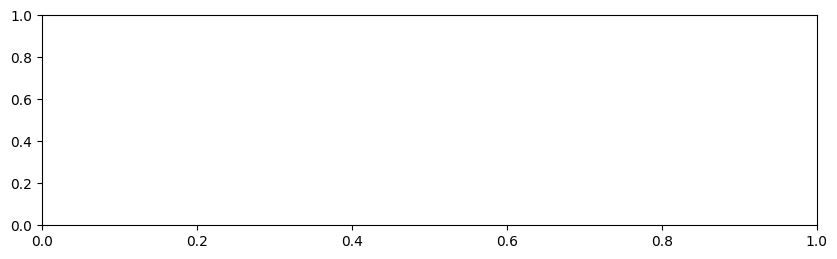

In [31]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, 10 + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.legend()